In [1]:
library(splatter)
library(Seurat)
library(dplyr)
set.seed(2024)

simmeta <- function(sim) {
  meta <- data.frame("CellType" = as.character(sim$Group),
                    "Batch" = paste0("Batch ", 
                                      as.factor(as.numeric(as.factor(sim$Batch)))))
  meta$CellType = gsub("Group", "Group ", meta$CellType)
  rownames(meta) <- sim$Cell
  return(meta)
}

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

# Simulated datasets with different batch effect sizes.

In [2]:
batch_sizes = seq(0.05, 0.25, 0.1)
X_list = list()
meta_list = list()
for (i in 1:length(batch_sizes)) {
  batch_size = batch_sizes[i]
  Sim = splatSimulate(batchCells  =  c(2000, 2000, 2000), batch.facScale  =  c(batch_size, batch_size, batch_size),
                      group.prob  = c(0.1, 0.2, 0.2, 0.4, 0.1), method = "groups", nGenes = 2000, verbose = FALSE)
  X = assay(Sim, "counts")
  meta = simmeta(Sim)
  seurat_obj = CreateSeuratObject(X, meta.data = meta, min.features = 0) %>% NormalizeData()
  X = seurat_obj@assays$RNA@data
  X_list[[i]] = X
  meta_list[[i]] = meta
}

Loading required package: ggplot2

Compute the group technical effects!

Done!



[[1]]
[1] 0.1883922

[[2]]
[1] 0.7415553

[[3]]
[1] 2.155135

[[1]]
[1] 800

[[2]]
[1] 1200

[[3]]
[1] 1600

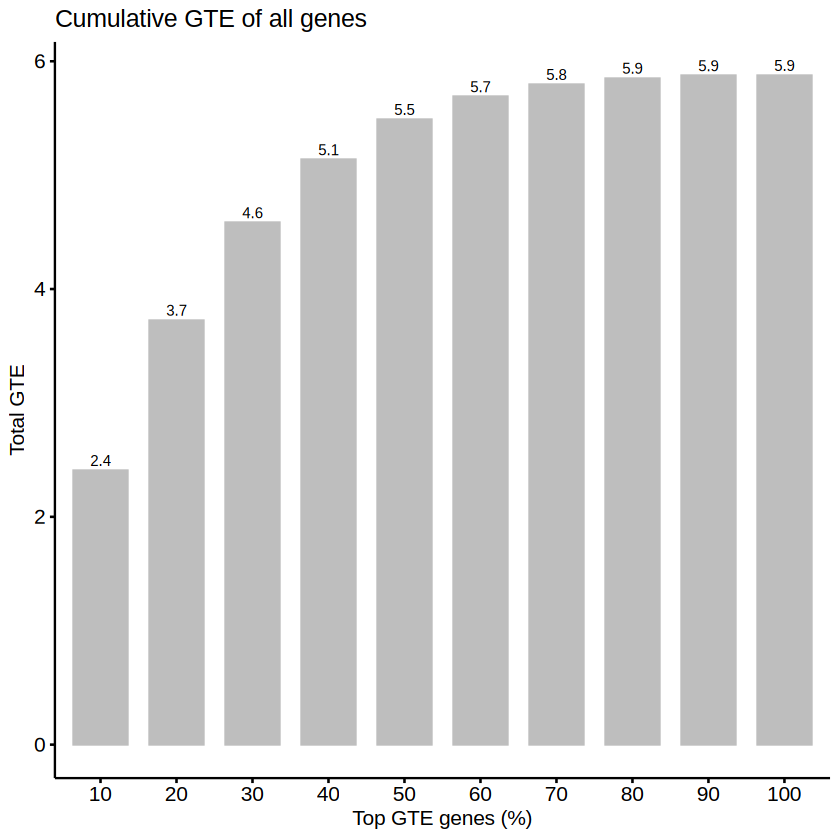

In [3]:
library(GTE)
library(ggpubr)
GTE_ct = Run.GroupTechEffects(X_list[[1]], meta_list[[1]], g_factor = "CellType", b_factor = "Batch")
plot_overall <- function(gte, genes) {
  gte = sort(gte[genes], decreasing = F)
  quantile_nums <- findInterval(quantile(gte, probs = seq(0, 0.9, 0.1)), gte)
  cum_gte = rev(cumsum(rev(unname(gte))))
  df = data.frame(GTE = rev(cum_gte[quantile_nums]),
                  Percentage = c('10', '20', '30', '40', '50', '60', '70', '80', '90', '100'))
  ggbarplot(df, x = "Percentage", y = "GTE",  
            legend = "none", fill = "gray", color = "gray", 
            font.label = list(size = 8, face = "plain"), width = 0.7, alpha = 1, 
            label = round(df$GTE, 1), lab.size = 3, lab.col = "black", lab.pos = "out") + 
    labs(x = "Top GTE genes (%)", y = "Total GTE")
}
plot_overall(GTE_ct$OverallTechEffects, rownames(X_list[[1]])) + labs(title = "Cumulative GTE of all genes")
gene_list = lapply(rev(seq(0.2, 0.6, 0.2)), function(i) {
    x = sort(GTE_ct$OverallTechEffects, decreasing = F)
    names(x[x <= quantile(x, 1-i)])
})
lapply(gene_list, function(x) sum(GTE_ct$OverallTechEffects[x]))
lapply(gene_list, length)

X0_list = lapply(gene_list, function(g) X_list[[1]][g, ])
meta0 = meta_list[[1]]

In [4]:
X_list = c(X0_list, X_list)
meta_list = c(meta_list, list(meta0, meta0, meta0))
str(X_list)
str(meta_list)

List of 6
 $ :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:2603100] 87 88 102 105 110 122 124 128 132 145 ...
  .. ..@ p       : int [1:6001] 0 433 897 1339 1756 2223 2721 3162 3581 4002 ...
  .. ..@ Dim     : int [1:2] 800 6000
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:800] "Gene321" "Gene801" "Gene898" "Gene1246" ...
  .. .. ..$ : chr [1:6000] "Cell1" "Cell2" "Cell3" "Cell4" ...
  .. ..@ x       : num [1:2603100] 0.158 0.158 0.158 0.158 0.158 ...
  .. ..@ factors : list()
 $ :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  .. ..@ i       : int [1:4827087] 87 88 102 105 110 122 124 128 132 145 ...
  .. ..@ p       : int [1:6001] 0 808 1655 2470 3258 4107 4992 5806 6595 7377 ...
  .. ..@ Dim     : int [1:2] 1200 6000
  .. ..@ Dimnames:List of 2
  .. .. ..$ : chr [1:1200] "Gene321" "Gene801" "Gene898" "Gene1246" ...
  .. .. ..$ : chr [1:6000] "Cell1" "Cell2" "Cell3" "Cell4" ...
  .. ..@ x       : num [1:4827087] 0.158 0.158 0.158 0